# Titanic EDA V2 - Feature Analysis for Modeling
This notebook evaluates new engineered features intended for inclusion in the v2 model.  
It builds upon the previous EDA (`eda_titanic_v1_based_on_raw_data_2025-07-21.ipynb`) and focuses on analyzing the predictive potential of custom-created features.  

## Goals

- Visualize the distribution of engineered features
- Understand their correlation with the target (`Survived`)
- Decide whether they are useful for modeling

## Table of Content

1. **Import Dependencies & Load Dataset** 載入套件與資料
2. **Planned Feature Analysis List** 特徵列表與預計分析順序
3. **Feature Engineering** 特徵工程
   - 3.1 Title (from Name)
   - 3.1-1 Title_Grouped
   - 3.2 FamilySize (= SibSp + Parch + 1)
   - 3.3 IsAlone (derived from FamilySize)
   - 3.4 FarePerPerson (= Fare / FamilySize)
   - 3.5 Deck (extracted from Cabin)
4. **Final Feature Summary & Export**
   - Final feature list
   - Save feature-enhanced dataset

## 1. Import Dependencies & Load Dataset 載入套件與資料

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 載入原始資料
train = pd.read_csv("../data/train.csv")
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Planned Feature Analysis List 特徵列表與預計分析順序

We will evaluate the following features one by one:  
1. `Title` - extracted from `Name`
2. `FamilySize` - SibSp + Parch + 1
3. `IsAlone` - binary version of FamilySize
4. `FarePerPerson` - Fare / FamilySize
5. `Deck` - extracted from Cabin (optional)  

Each feature will be analyzed by:
- Value distribution (univariate)
- Survival rate correlation (bivariate)
- Potential issues (skewed classes, missing values, etc.)

**Note on Previously Analyzed Features:**  
The following features were already thoroughtly analyzed in **EDA V1** and will note be repeated in EDA V2:  
- `Sex` - Strong correlation with survival. Females had significantly higher survival rates.
- `Pclass` - Lower-class passengers (Pclass = 3) had much lower survival rates.
- `Age` - Distribution showed bimodality and non-survival skew toward adults. Some missing values were also noted.

These features will be directly considered for modeling in V2 without redundant analysis here,.

## 3. Feature Engineering 特徵工程

### 3.1 `Title`

In [36]:
# 萃取 Title
def extract_title(name):
    return name.split(',')[1].split('.')[0].strip()

train['Title'] = train['Name'].apply(extract_title)

print(train['Title'].value_counts())

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64


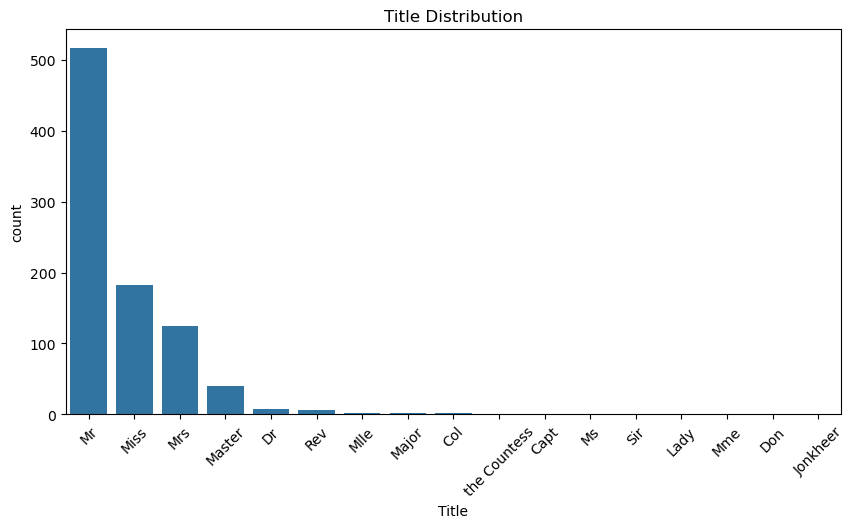

In [37]:
# 視覺化 Title 的分佈
plt.figure(figsize=(10,5))
sns.countplot(data=train, x='Title', order=train['Title'].value_counts().index)
plt.title('Title Distribution')
plt.xticks(rotation=45)
plt.show()

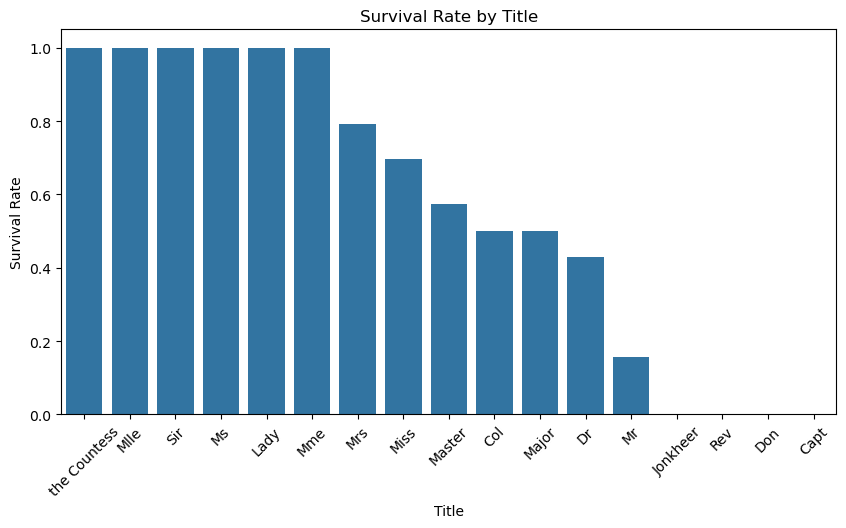

In [38]:
# Title 與生還率的關係
title_survival = train.groupby('Title')['Survived'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=title_survival.index, y=title_survival.values)
plt.title('Survival Rate by Title')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45)
plt.show()

#### Summary: Insights on `Title`
- The most common titles are `Mr`, `Miss` and `Mrs`.  
- Rare titles such as `Don`, `Rev`, `Jonkheer`, `Capt`, `Sir`, `Countess`, and `Lady` appear very infrequently (fewer than 10 times).  
- Some rare titles like `Countess` and `Mme` show high survival rates, but the sample sizes are too small to draw meaningful conclustions.  

**Conclusion:** To prevent model distortion caused by infrequent categoriesm we will group all titles that occur fewer than 10 times into a single category called `Rare`. We will continue with this analysis in section **3.1-1** `Title_Grouped`.  

### 3.1-1 `Title_Grouped`

In [25]:
# 萃取 Title
def extract_title(name):
    return name.split(',')[1].split('.')[0].strip()

train['Title'] = train['Name'].apply(extract_title)

# 建立 Title_Grouped 欄位
# 找出所有出現次數少於 10 的 Title
title_counts = train['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index.tolist()

# 建立新欄位 Title_Grouped，將稀有稱謂歸為 Rare
train['Title_Grouped'] = train['Title'].apply(lambda x: 'Rare' if x in rare_titles else x)

# 看看分組後有哪些 Title
print(train['Title_Grouped'].value_counts())

Title_Grouped
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64


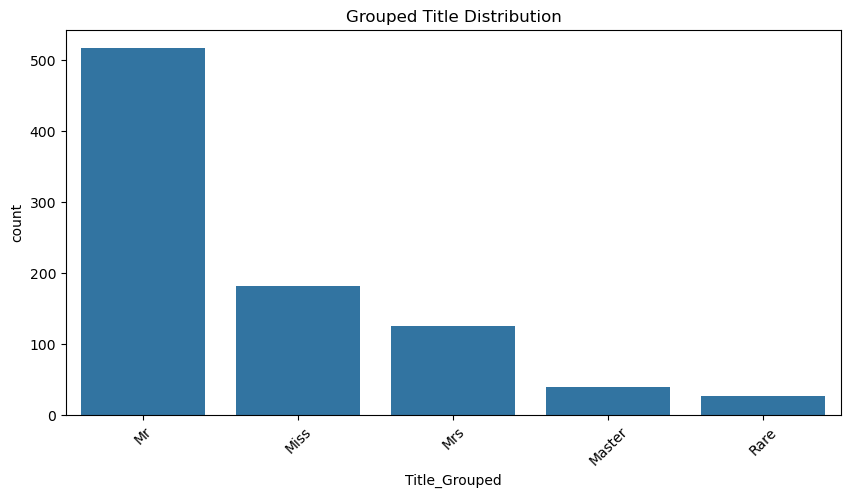

In [26]:
# 視覺化 Grouped Title 的分佈
plt.figure(figsize=(10,5))
sns.countplot(data=train, x='Title_Grouped', order=train['Title_Grouped'].value_counts().index)
plt.title('Grouped Title Distribution')
plt.xticks(rotation=45)
plt.show()

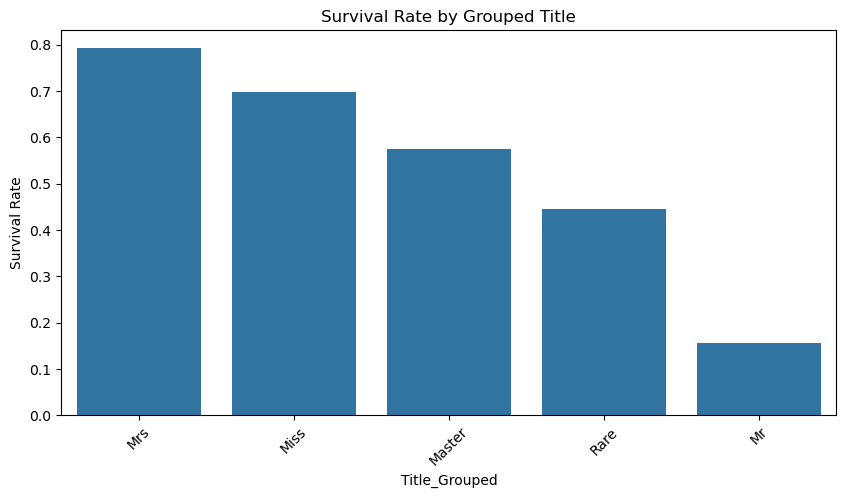

In [33]:
# Grouped Title 與生還率的關係
title_grouped_survival = train.groupby('Title_Grouped')['Survived'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=title_survival.index, y=title_survival.values)
plt.title('Survival Rate by Grouped Title')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45)
plt.show()

In [34]:
title_grouped_survival

Title_Grouped
Mrs       0.792000
Miss      0.697802
Master    0.575000
Rare      0.444444
Mr        0.156673
Name: Survived, dtype: float64

#### Summary: Insights on `Title_Grouped`
- `Mrs` has the highest survival rate at **79.2%**, followed by `Miss` (**69.8%**) and `Master` (**57.5%**).
- `Rare` titles have a moderate survival rate of **44.4%**, indicating some signal but less consistency.
- `Mr` has the lowest survival rate at **15.7%**, suggesting strong correlation with non-survival.

**Conclustion:** `Title_Grouped` demonstrates a clear relationship with survival outcome. This variable will be **retianed as a categorical feature** for model training.

### 3.2 `FamilySize` (= SibSp + Parch + 1)